In [3]:
import autograd.numpy as np
from autograd import grad, hessian_vector_product
from scipy.optimize import minimize as sp_minimize
from autograd.scipy.special import logsumexp
import autograd.scipy.stats.multivariate_normal as mvn
from autograd.misc.flatten import flatten_func
from data import make_pinwheel

import matplotlib.pyplot as plt
# from pymir import mpl_stylesheet
# from pymir import mpl_utils
# mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [4]:
def init_gmm_params(num_components, D, scale, rs=np.random.RandomState(0)):
    return {'log proportions': rs.randn(num_components) * scale,
            'means':           rs.randn(num_components, D) * scale,
            'lower triangles': np.zeros((num_components, D, D)) + np.eye(D)}

def log_normalize(x):
    return x - logsumexp(x)

def unpack_gmm_params(params):
    normalized_log_proportions = log_normalize(params['log proportions'])
    return normalized_log_proportions, params['means'], params['lower triangles']

def gmm_log_likelihood(params, data):
    cluster_lls = []
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params)):
        cov = np.dot(cov_sqrt.T, cov_sqrt)
        cluster_lls.append(log_proportion + mvn.logpdf(data, mean, cov))
    return np.sum(logsumexp(np.vstack(cluster_lls), axis=0))

def plot_ellipse(ax, mean, cov_sqrt, alpha, num_points=100):
    angles = np.linspace(0, 2*np.pi, num_points)
    circle_pts = np.vstack([np.cos(angles), np.sin(angles)]).T * 2.0
    cur_pts = mean + np.dot(circle_pts, cov_sqrt)
    ax.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha)

def plot_gaussian_mixture(params, ax):
    for log_proportion, mean, cov_sqrt in zip(*unpack_gmm_params(params)):
        alpha = np.minimum(1.0, np.exp(log_proportion) * 10)
        plot_ellipse(ax, mean, cov_sqrt, alpha)

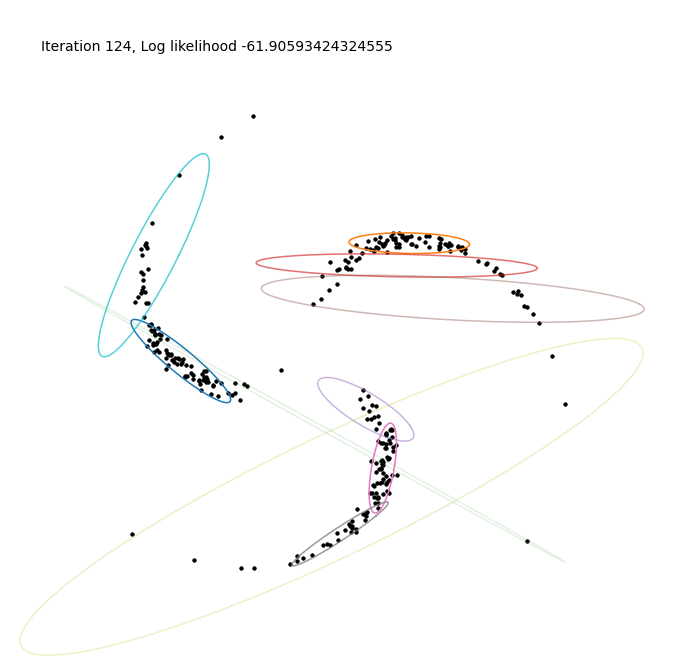

In [6]:
%matplotlib inline

from IPython import display
import time

init_params = init_gmm_params(num_components=10, D=2, scale=0.1)

data = make_pinwheel(radial_std=0.3, tangential_std=0.05, num_classes=3,
                     num_per_class=100, rate=0.4)

def objective(params):
    return -gmm_log_likelihood(params, data)

flattened_obj, unflatten, flattened_init_params =\
    flatten_func(objective, init_params)


nclbk = 0
xmin = np.min(data)
xmax = np.max(data)
xmin = xmin - (xmax - xmin) * 0.2
xmax = xmax + (xmax - xmin) * 0.2

def callback(flattened_params):
    global nclbk, xmin, xmax
    params = unflatten(flattened_params)
    obj = -objective(params)
    # show live plot
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(12,12), facecolor='white')
    ax = fig.add_subplot(111, frameon = False)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.plot(data[:, 0], data[:, 1], 'k.')
    ax.text(0.05, 0.95, f"Iteration {nclbk}, Log likelihood {obj}", 
            va='top', ha='left', transform=ax.transAxes, color = 'k', 
            fontsize=14)
    ax.plot(data[:, 0], data[:, 1], 'k.')
    ax.set_xticks([])
    ax.set_yticks([])
    plot_gaussian_mixture(params, ax)
    #plt.draw()
    plt.show()
    plt.pause(1.0/60.0)
    nclbk = nclbk + 1

callback(flattened_init_params)

opt = sp_minimize(flattened_obj, flattened_init_params,
    jac=grad(flattened_obj),
    hessp=hessian_vector_product(flattened_obj),
    method='Newton-CG', callback=callback,
    options = {'maxiter': 1000})

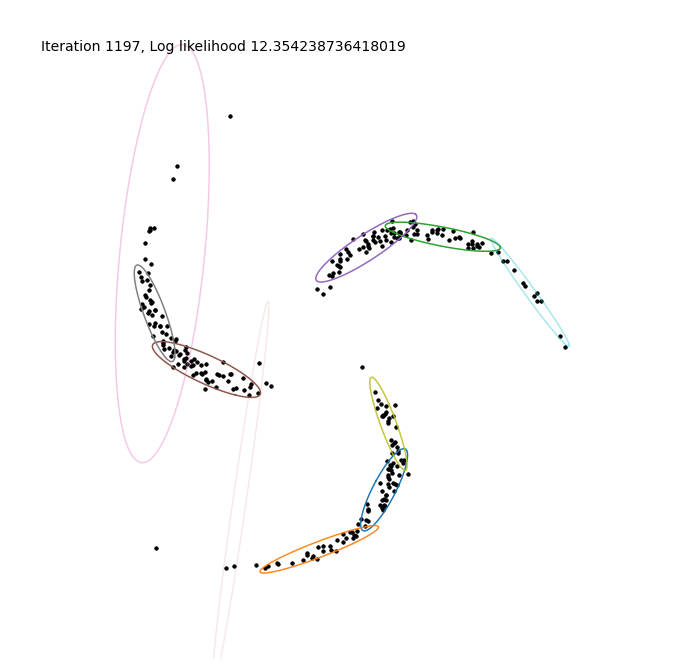

In [21]:
nclbk = 0
opt_lbfgs = sp_minimize(flattened_obj, flattened_init_params,
    jac=grad(flattened_obj),
    method='L-BFGS-B', callback=callback,
    options = {'maxiter': 10000})

In [22]:
opt_lbfgs

      fun: -12.354238736418019
 hess_inv: <70x70 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.91066474e-03, -2.10947879e-03,  1.18386923e-03,  1.31498830e-03,
        2.16163094e-03,  1.79964303e-03, -1.28141594e-03, -4.30699170e-03,
        2.72203054e-04, -1.94511286e-03,  3.82675633e-02, -2.06947272e-02,
       -7.15107730e-03, -6.68690547e-03,  3.38909512e-03, -1.13108116e-02,
       -3.86555640e-03,  4.76535606e-03, -3.55751351e-03,  6.93902660e-03,
        8.68666421e-03,  3.92413290e-02, -2.81838742e-03,  1.24070592e-04,
       -1.26368996e-02,  1.20484640e-03,  7.19277655e-03,  4.13623713e-03,
       -2.76502816e-03,  2.99461837e-03, -3.25501669e-03,  7.69313748e-04,
        4.20068050e-03, -1.34060169e-03, -2.81382441e-03,  3.70903578e-04,
        5.94612069e-04,  2.73668636e-04, -3.06515771e-03, -6.31950665e-04,
       -5.83484053e-04, -7.74727054e-04,  4.67619376e-03, -1.98285840e-03,
       -2.79654587e-05, -8.75742956e-03, -7.30470238e-03, -4.83311855e-03,
